In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import statistics as st
from datetime import datetime
import numpy as np
import os
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = True if torch.cuda.is_available() else False
print('We are using GPU.' if use_cuda else 'We are using CPU.')
print(device)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

We are using GPU.
cuda


In [3]:
root_dir = "Cat and Dog/dataset"

In [4]:
os.listdir(root_dir)

['test_set', 'training_set']

In [5]:
transforming = transforms.Compose([#transforms.RandomResizedCrop(224),
                                   #transforms.ToPILImage(),
                                   transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   #transforms.RandomHorizontalFlip(),
                                   #transforms.RandomVerticalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485,0.456,0.406],
                                                        std=[0.229,0.224,0.225])
                                   ])

In [6]:
train_dataset = ImageFolder(root = os.path.join(root_dir,"training_set"),
                           transform=transforming)

test_dataset = ImageFolder(root = os.path.join(root_dir,"test_set"),
                           transform=transforming)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


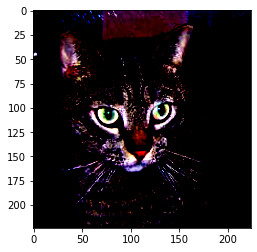

In [7]:
a = iter(train_dataset)
b = next(a)


plt.imshow(np.transpose(b[0],(1,2,0)))

In [8]:
print(train_dataset.classes)
train_dataset.class_to_idx
print(len(train_dataset))

['cats', 'dogs']
8000


In [9]:
batch_size=10
train_data = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)
test_data = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=1,pin_memory=True)

In [21]:
dend_model = models.densenet201(pretrained=True)
#den_model
for params in dend_model.parameters():
    params.requires_grad=False
dend_model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:

class Dense_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
                       dend_model.train(),
                       nn.Linear(1000,500),
                       nn.Linear(500,100),
                       nn.Linear(100,2))
                       #nn.LogSoftmax(dim=1))
        
    def forward(self,aa):
        return self.network(aa)

In [ ]:
###another way change the classifier section in pretrained network###

# from collections import OrderedDict
# classifier = nn.Sequential(OrderedDict([
#     ('fc1',nn.Linear(1920,500)),
#     ('relu',nn.ReLU()),
#     ('fc2',nn.Linear(500,2)),
#     ('Output',nn.LogSoftmax(dim=1))
# ]))

# dend_model.classifier = classifier
# dend_model = den_model.to(device)
# dend_model

In [23]:
dense_model = Dense_Network().to(device)
dense_model

# for x,y in train_data:
#     x,y=x.to(device),y.to(device)
#     aa = dense_model(x)
#     print(aa)
#     __,pred = torch.max(aa,dim=1) 
#     print(pred)
#     print(y)
#     print(torch.sum(pred==y).item()/len(y))
#     break

Dense_Network(
  (network): Sequential(
    (0): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer(
 

In [24]:
losses = F.cross_entropy
#losses = nn.NLLLoss()
opti = torch.optim.Adam(dense_model.parameters(),lr=0.001)

num_epoch = 15
start = datetime.now()
acc_his=[]
for x in range(num_epoch):
    correct=[]
    n=0
    for data,target in train_data:
        n+=1
        data,target = data.to(device),target.to(device)
        dense_model.train()
        pred = dense_model(data)
        loss = losses(pred,target)
        loss.backward()
        opti.step()
        opti.zero_grad()
        __,pre = torch.max(pred,dim=1)
        acc = torch.sum(pre==target).item()/len(target)
        accc =torch.sum(pre==target).item()
        correct.append(accc)
        if n%10==0:
            print("Accuracy:{}, loss: {} with # {}".format(acc,loss.item(),n))
    acc_his.append(sum(correct)/len(train_dataset))
    if (x+1)%1==0:
        print("Epoch number[{}/{}],accuracy:{},loss:{}".format(x+1,num_epoch,sum(correct)/len(train_dataset),loss.item()))

Accuracy:0.7, loss: 1.3704583644866943 with # 10
Accuracy:0.9, loss: 0.7090266942977905 with # 20
Accuracy:0.9, loss: 0.5344514846801758 with # 30
Accuracy:0.9, loss: 0.17670384049415588 with # 40
Accuracy:1.0, loss: 0.008808267302811146 with # 50
Accuracy:1.0, loss: 0.014888840727508068 with # 60
Accuracy:1.0, loss: 0.04363735765218735 with # 70
Accuracy:1.0, loss: 0.011269068345427513 with # 80
Accuracy:1.0, loss: 0.042538564652204514 with # 90
Accuracy:1.0, loss: 0.06957312673330307 with # 100
Accuracy:0.8, loss: 0.3475450873374939 with # 110
Accuracy:0.9, loss: 0.24715328216552734 with # 120
Accuracy:1.0, loss: 0.023192118853330612 with # 130
Accuracy:0.9, loss: 0.27074941992759705 with # 140
Accuracy:0.8, loss: 0.217136949300766 with # 150
Accuracy:1.0, loss: 0.008456719107925892 with # 160
Accuracy:0.9, loss: 0.24563005566596985 with # 170
Accuracy:1.0, loss: 0.044406093657016754 with # 180
Accuracy:1.0, loss: 0.026075422763824463 with # 190
Accuracy:0.9, loss: 0.2217013388872146

Accuracy:1.0, loss: 0.014587104320526123 with # 770
Accuracy:1.0, loss: 0.033692874014377594 with # 780
Accuracy:1.0, loss: 0.023297518491744995 with # 790
Accuracy:0.8, loss: 1.0446577072143555 with # 800
Epoch number[4/15],accuracy:0.944125,loss:1.0446577072143555
Accuracy:1.0, loss: 0.013382804580032825 with # 10
Accuracy:0.9, loss: 0.15483352541923523 with # 20
Accuracy:1.0, loss: 0.03099464811384678 with # 30
Accuracy:1.0, loss: 0.0049446821212768555 with # 40
Accuracy:1.0, loss: 0.022779177874326706 with # 50
Accuracy:0.9, loss: 0.27698588371276855 with # 60
Accuracy:0.9, loss: 0.18159978091716766 with # 70
Accuracy:1.0, loss: 0.025259751826524734 with # 80
Accuracy:1.0, loss: 0.06160601228475571 with # 90
Accuracy:1.0, loss: 0.016613392159342766 with # 100
Accuracy:0.8, loss: 0.2385934293270111 with # 110
Accuracy:1.0, loss: 0.05716531723737717 with # 120
Accuracy:0.9, loss: 0.11252335458993912 with # 130
Accuracy:0.9, loss: 0.14641186594963074 with # 140
Accuracy:1.0, loss: 0.0

Accuracy:1.0, loss: 0.010589003562927246 with # 710
Accuracy:0.9, loss: 0.1634804904460907 with # 720
Accuracy:1.0, loss: 0.046740759164094925 with # 730
Accuracy:0.9, loss: 0.17085376381874084 with # 740
Accuracy:0.8, loss: 0.46720361709594727 with # 750
Accuracy:0.9, loss: 0.2804775834083557 with # 760
Accuracy:0.8, loss: 0.3288115859031677 with # 770
Accuracy:0.8, loss: 0.2761158347129822 with # 780
Accuracy:1.0, loss: 0.024098116904497147 with # 790
Accuracy:1.0, loss: 0.014748580753803253 with # 800
Epoch number[8/15],accuracy:0.951,loss:0.014748580753803253
Accuracy:1.0, loss: 0.028178159147500992 with # 10
Accuracy:1.0, loss: 0.0038576126098632812 with # 20
Accuracy:1.0, loss: 0.0061370013281702995 with # 30
Accuracy:1.0, loss: 0.044660914689302444 with # 40
Accuracy:1.0, loss: 0.015634501352906227 with # 50
Accuracy:1.0, loss: 0.002259206725284457 with # 60
Accuracy:0.9, loss: 0.0889936164021492 with # 70
Accuracy:1.0, loss: 0.00557074137032032 with # 80
Accuracy:0.9, loss: 0.5

Accuracy:1.0, loss: 0.00038754940032958984 with # 640
Accuracy:1.0, loss: 0.07643453776836395 with # 650
Accuracy:1.0, loss: 0.0016084581147879362 with # 660
Accuracy:1.0, loss: 0.23877564072608948 with # 670
Accuracy:1.0, loss: 0.015701550990343094 with # 680
Accuracy:1.0, loss: 0.0015217543113976717 with # 690
Accuracy:1.0, loss: 0.020181477069854736 with # 700
Accuracy:0.8, loss: 0.42807093262672424 with # 710
Accuracy:0.9, loss: 0.21514491736888885 with # 720
Accuracy:0.9, loss: 0.2591530680656433 with # 730
Accuracy:0.9, loss: 0.08542677760124207 with # 740
Accuracy:0.9, loss: 0.13473469018936157 with # 750
Accuracy:1.0, loss: 0.06057783216238022 with # 760
Accuracy:1.0, loss: 0.0021583200432360172 with # 770
Accuracy:0.9, loss: 0.4663168787956238 with # 780
Accuracy:1.0, loss: 0.0270063616335392 with # 790
Accuracy:1.0, loss: 0.0632195845246315 with # 800
Epoch number[12/15],accuracy:0.95375,loss:0.0632195845246315
Accuracy:1.0, loss: 0.003609991166740656 with # 10
Accuracy:1.0, 

In [27]:
###test###
with torch.no_grad():
    result=[]
    for x,y in test_data:
        x,y=x.to(device),y.to(device)
        dense_model.eval()
        prediction=dense_model(x)
        __,predict=torch.max(prediction,dim=1)
        result.append(torch.sum(predict==y).item())
    print("Performance on testdata is:{}",format(sum(result)/len(test_dataset)))

Performance on testdata is:{} 0.98


In [27]:
x = torch.Tensor([1,2,3,4,7])
y = [2,3]
a = enumerate(x)
print(list(a))

[(0, tensor(1.)), (1, tensor(2.)), (2, tensor(3.)), (3, tensor(4.)), (4, tensor(7.))]


In [34]:
for xx,yy in enumerate(x):
    print(xx)
    print(yy)

0
tensor(1.)
1
tensor(2.)
2
tensor(3.)
3
tensor(4.)
4
tensor(7.)


In [32]:
print(a)